In [268]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [269]:
data_path = '/Users/user1/Desktop/nfl-big-data-bowl-2025/plays.csv'

In [270]:
play_data = pd.read_csv(data_path)

In [271]:
# Drop columns not needed for modeling (like playDescription)
# playDescription is a textual description of the play, which is valuable for human understanding but not directly useful for machine learning models. 
# Avoids unnecessary complexity, and reduces noise in the data for modeling.
play_data.drop(['playDescription'], axis=1, inplace=True)

# Convert the 'gameClock' column from 'MM:SS' format to total 
# This gives us a single numerical value (total seconds remaining)
# The try-except block is there to handle cases where the format might be incorrect (e.g., malformed time strings). If that happens, it returns np.nan so that missing or malformed data is handled appropriately.
def convert_time_to_seconds(time_str):
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return np.nan  # Handle any potential issues with malformed time strings

# Apply the conversion to the gameClock column
# This ensures that each row's gameClock value is converted from MM:SS to total seconds, giving us a numeric value that can be used in machine learning models.
play_data['gameClock'] = play_data['gameClock'].apply(convert_time_to_seconds)

In [272]:
# Convert 'Y'/'N' columns to 0/
# Turns these categorical columns into binary numerical features (0s and 1s), which models can easily use.
yn_columns = ['playNullifiedByPenalty', 'passTippedAtLine', 'unblockedPressure', 'qbSpike', 'qbSneak']

# Convert 'Y' to 1 and 'N' to 0 for these columns
# map({'Y': 1, 'N': 0}) is used to replace 'Y' (Yes) with 1 and 'N' (No) with 0
for col in yn_columns:
    play_data[col] = play_data[col].map({'Y': 1, 'N': 0})

In [273]:
# Handle missing values with a valid placeholder (e.g., "None")
play_data['pff_passCoverage'] = play_data['pff_passCoverage'].fillna('None')
play_data['passResult'] = play_data['passResult'].fillna('None')
play_data['offenseFormation'] = play_data['offenseFormation'].fillna('None')
play_data['rushLocationType'] = play_data['rushLocationType'].fillna('None')
play_data['receiverAlignment'] = play_data['receiverAlignment'].fillna('None')  # Also fill missing values for receiverAlignment


In [274]:
# List of all relevant categorical columns that need to be encoded
categorical_columns = ['yardlineSide', 'possessionTeam', 'defensiveTeam', 'offenseFormation', 
                       'pff_passCoverage', 'dropbackType', 'passLocationType', 'rushLocationType', 
                       'passResult', 'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_manZone',
                       'receiverAlignment']  # Added receiverAlignment for encoding


In [275]:
# Apply one-hot encoding using pd.get_dummies on all categorical columns
# One-hot encoding creates binary columns (0 or 1) for each category, where a 1 indicates the presence of that category in a particular row, and 0 indicates the absence.
# pd.get_dummies() converts categorical features (like team abbreviations or formations) into multiple binary columns (one for each category) so that the machine learning model can interpret these features as separate, independent inputs.
play_data_encoded = pd.get_dummies(play_data, columns=categorical_columns, drop_first=True)

In [276]:
# Select numeric columns (including converted 'gameClock')
numeric_columns = ['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'yardsGained', 
                   'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded', 'gameClock']


In [277]:
# Combine the one-hot encoded columns and numeric columns for the final feature set
# The machine learning model needs to be trained on both numerical features and one-hot encoded categorical features.
# This step creates a combined dataset (X) that includes all relevant features for training.
X = play_data_encoded[numeric_columns + list(play_data_encoded.columns.difference(numeric_columns + ['expectedPointsAdded']))]

# Expected Points Added (EPA) is a numerical value that measures the expected impact of a particular play on the team’s chances of scoring. 
# It is a critical output in football analytics that can indicate how well a play contributed to the team's success.
y = play_data_encoded['expectedPointsAdded']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)


In [15]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.19203186050962234
R-squared: 0.8946306440491423


### Mean Squared Error (MSE): 0.192
This means, on average, the model's predictions are off by about 0.192 points compared to the actual expected points added.

### R-squared (R²): 0.895
This indicates that the model explains about 89.5% of the variance in the target variable (expectedPointsAdded), which is a strong result.

### Interpretation:
High R-squared: The model is performing well in predicting the expected points added for each play, meaning it can provide valuable insights for decision-making in football strategy.
Low MSE: The model has relatively low error, which means it's making accurate predictions.

## Scenario 1

In [258]:
import numpy as np

# Scenario details (ensure they match the columns in the model)
scenario = {
    'quarter': 4,
    'down': 3,
    'yardsToGo': 5,
    'yardlineNumber': 25,
    'homeTeamWinProbabilityAdded': 0.02,
    'visitorTeamWinProbilityAdded': -0.02,
    'yardsGained': 3,
    'yardlineSide_CIN': 1,  # one-hot encoded
    'possessionTeam_BUF': 1,  # one-hot encoded
    'defensiveTeam_CIN': 1,  # one-hot encoded
    'offenseFormation_SHOTGUN': 1,  # one-hot encoded
    'pff_passCoverage_Cover-3': 1  # one-hot encoded
}

In [278]:
# Initialize input_data as a zero-filled DataFrame with the same columns as the model
# Purpose of this step is to set up a blank input (with all features initialized to zero) that can later be filled in with a specific scenario's data for making predictions.
scenario_df = pd.DataFrame(np.zeros((1, len(X.columns))), columns=X.columns)

In [279]:
# Populate the input data DataFrame with the values from the scenario

# The key represents the column name (or feature name) corresponding to some aspect of the play (e.g., down, yardlineNumber, possessionTeam).
# The value is the specific value for that feature in this scenario (e.g., down = 3, possessionTeam = BUF).

for key, value in scenario.items():
    if key in X.columns:
        scenario_df[key] = value

In [239]:
# Use the trained model to predict the expected points added for this scenario
predicted_epa = rf_model.predict(scenario_df)
print(f"Predicted Expected Points Added: {predicted_expected_points[0]}")

Predicted Expected Points Added: -1.6948439945833527


In [240]:
import matplotlib.pyplot as plt

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

In [241]:
# Create a DataFrame to show feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [242]:
# Sort features by their importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [243]:
# Display the top 15 most important features
top_features = feature_importance_df.head(15)

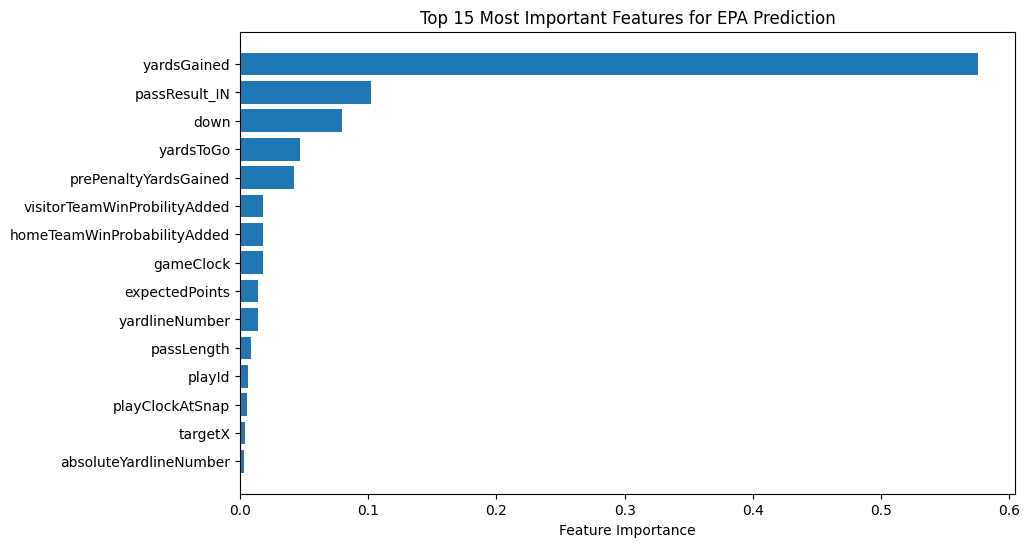

In [244]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for EPA Prediction')
plt.show()

In [245]:
# Show the full list of feature importances if desired
feature_importance_df.head(5)  # You can adjust this number to see more features

,Feature,Importance
4,yardsGained,0.575809
64,passResult_IN,0.102327
1,down,0.079455
2,yardsToGo,0.046784
179,prePenaltyYardsGained,0.042326


## Scenario 2

In [246]:
# Adjusted best offense vs worst defense scenario
new_scenario = {
    'quarter': 2,
    'down': 2,
    'yardsToGo': 7,  # Slightly longer yardage to go
    'yardlineNumber': 15,  # Move the offense farther from the end zone for more space
    'homeTeamWinProbabilityAdded': 0.15,
    'visitorTeamWinProbilityAdded': -0.15,
    'yardsGained': 10,  # Assume a positive gain of 8 yards to simulate a successful play
    'yardlineSide_KC': 1,  # Kansas City Chiefs on offense
    'possessionTeam_KC': 1,  # Kansas City possession
    'defensiveTeam_DET': 1,  # Detroit Lions on defense
    'offenseFormation_PISTOL': 1,  # PISTOL formation for balance between run and pass
    'pff_passCoverage_Cover-3': 1  # Cover-3 defense, typically vulnerable to deep passes
}

In [247]:
# Initialize input_data as a zero-filled DataFrame with the same columns as the model
new_scenario_df = pd.DataFrame(np.zeros((1, len(X.columns))), columns=X.columns)

In [248]:
# Populate the input data DataFrame with the values from the scenario
for key, value in new_scenario.items():
    if key in X.columns:
        new_scenario_df[key] = value

In [249]:
# Use the trained model to predict the expected points added for the new scenario
predicted_epa_new_scenario = rf_model.predict(new_scenario_df)
print(f"Predicted Expected Points Added for new scenario: {predicted_epa_new_scenario[0]}")

Predicted Expected Points Added for new scenario: 0.3008175634627697


In [250]:
# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to show feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [251]:
# Sort features by their importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 15 most important features
top_features = feature_importance_df.head(15)

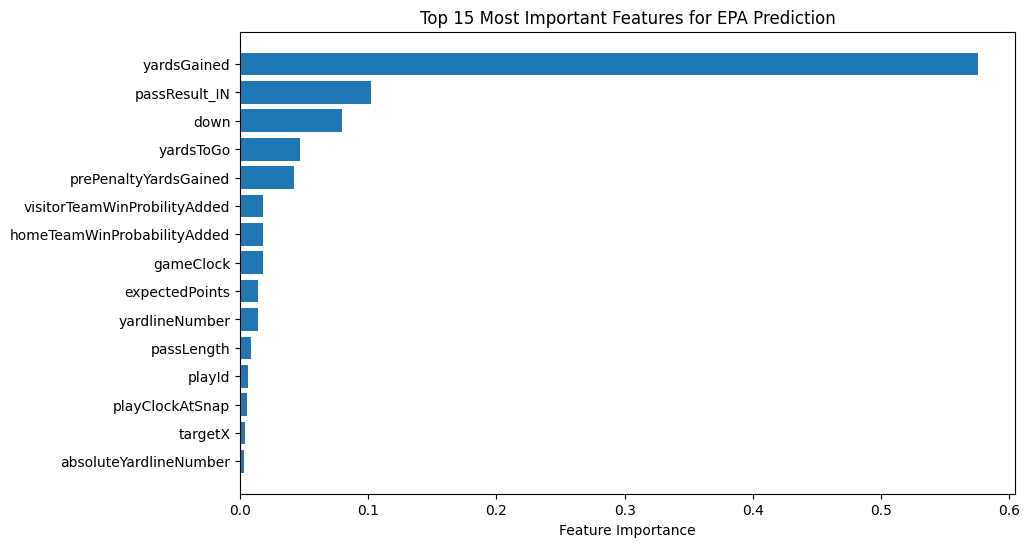

In [252]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for EPA Prediction')
plt.show()



In [253]:
# You can also view the full list of feature importances if desired
print(feature_importance_df.head(5))

                   Feature  Importance
4              yardsGained    0.575809
64           passResult_IN    0.102327
1                     down    0.079455
2                yardsToGo    0.046784
179  prePenaltyYardsGained    0.042326


## Compare the Scenarios

In [257]:
# Compare the two predictions
print(f"Previous Scenario EPA: {predicted_expected_points[0]}")
print(f"New Scenario EPA: {predicted_epa_new_scenario[0]}")

Previous Scenario EPA: -1.6948439945833527
New Scenario EPA: 0.3008175634627697


### Scenario 1: Negative EPA (-1.69)
- Quarter: 4th quarter, higher stakes and more pressure on the offense to succeed.
- Down: 3rd down, with 5 yards to go. Failing to convert increases the likelihood of a punt or turnover.
- Field Position: On the 25-yard line, likely in their own territory. Poor field position reduces scoring opportunities.
- Teams: BUF offense vs. CIN defense. Cincinnati’s defense, combined with Cover-3, may be limiting big plays, especially on 3rd down.
- Yards Gained: Only 3 yards, short of the first down, which increases the risk of failure.
#### Key Influential Factors:
- Field Position: Being far from the opponent’s end zone reduces the chance of scoring, leading to a negative EPA.
- Down and Distance: The failure to convert on 3rd down increases the risk of losing possession, resulting in a lower EPA.
- Defensive Scheme (Cover-3): This scheme is effective in preventing deep passes, which may limit yardage gains in this scenario.

### Scenario 2: Positive EPA (0.30)
- Quarter: 2nd quarter, with less immediate pressure compared to the 4th quarter.
- Down: 2nd down and 7 yards to go, offering more opportunities for the offense to continue the drive.
- Field Position: On the opponent’s 15-yard line, close to scoring, which significantly increases scoring chances.
- Teams: KC offense vs. DET defense. Kansas City’s high-powered offense against Detroit’s weaker defense gives the offense an edge.
- Yards Gained: 10 yards, enough to set up a first down and move even closer to the end zone, improving the chance of scoring.
#### Key Influential Factors:
- Field Position: Being in the red zone on the 15-yard line greatly increases scoring chances.
- Yards Gained: The offense gains 10 yards, which moves them closer to the end zone and sets up a potential first down.
- Team Matchup: Kansas City’s offense performs well against Detroit’s weaker defense, leading to a higher EPA.
- Formation (PISTOL): This formation gives the offense flexibility to run or pass, which might have contributed to the success of the play.

### Conclusion:
- Scenario 1 resulted in a negative EPA due to poor field position, high-pressure down (3rd), and only minimal yardage gained. The combination of Cincinnati’s defense and Cover-3 coverage made it difficult for the offense to succeed.
- Scenario 2 resulted in a positive EPA due to favorable field position, successful yardage gain, and a weaker defense, setting up the offense for a potential scoring opportunity. The earlier quarter and down also provided more flexibility for the offense.